### a rule based job seeker chatbot


In [119]:
import pandas as pd
import numpy as np
import nltk
import nltk.corpus
import matplotlib.pyplot as plt
from tqdm import tqdm

from nltk import FreqDist

import spacy

from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords 

import gensim
from gensim import corpora
from gensim import models
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from nltk.corpus import stopwords

from spacy.util import minibatch, compounding
from spacy.training.example import Example
import random

import json

from spacy import displacy
from spacy.matcher import Matcher

import string # to process standard python strings
import telegram
from telegram.ext import Updater, MessageHandler, Filters

In [120]:
seek_df = pd.read_csv('seek_australia.csv')
# seek_df = seek_df.iloc[:100,:]

Due to the long running time of cleaning data (about three hours), I have exported the cleaned data as clean.csv, which can be used directly

In [122]:
# special = ['â','€','™','Â','œ','\xa0','\x9d']
for i in tqdm(range(len(seek_df))):
    for j in range(len(str(seek_df['job_description'][i]))):
        seek_df['job_description'][i] = str(seek_df['job_description'][i]).replace('Â ', ' ').replace('â€™', "\'").replace('œ', '').replace('Â\xa0', '').replace(
            '\xa0', '').replace('\x9d', '').replace('â', '').replace('€', '').replace('\\s', '').replace('¢', '').replace('®', '').replace('Â', '').replace('Â·', '')
        #j -= 1


100%|██████████| 30000/30000 [3:01:01<00:00,  2.76it/s]  


In [ ]:
# seek_df.to_csv('clean.csv')

In [3]:
seek_df = pd.read_csv('clean.csv')

### Data Exploration

#### 1 What are the unique Job categories in the dataset for each city? Visualise the frequency of job categories, allowing city being a variable. 

In [4]:
def city_job(city):
    city_df=seek_df[seek_df['city']==city]    
    city_df['category'].value_counts().plot.bar()
    plt.show()

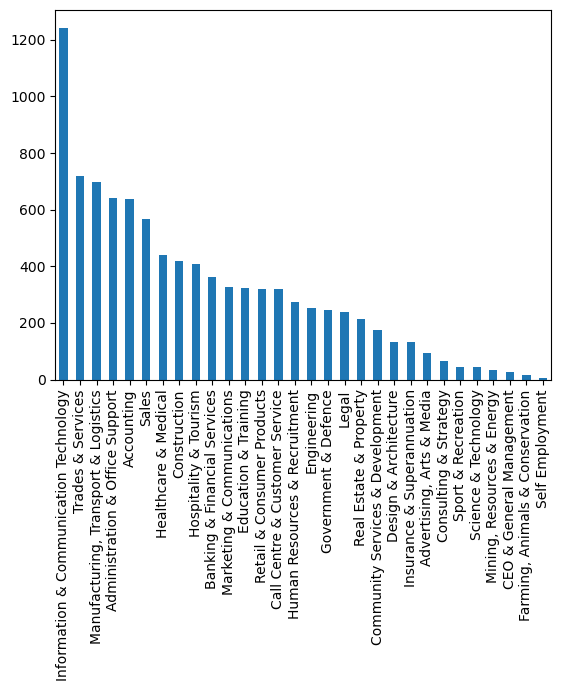

In [5]:
city_job('Sydney')

#### 2 Work out the vocabulary used by each job category, respectively. Visualise the Word Frequency.

In [6]:
from nltk import FreqDist

def cate_des(category):
    with open('job_description.txt', 'w') as f:
        for i in range(len(seek_df)):
            if seek_df['category'][i]==category:
                f.write(str(seek_df["job_description"][i])+'\r\n')
    job_text = nltk.Text(nltk.word_tokenize(open('job_description.txt').read()))
    job_fdist = FreqDist(job_text)
    # The frequency distribution of top fifty words.
    plt.figure(figsize=(10, 5))  # change figsize to (width, height)
    job_fdist.plot(50)
    #The cumulative frequency distribution of top fifty words.
    plt.figure(figsize=(10, 5))  # change figsize to (width, height)
    job_fdist.plot(50, cumulative=True)

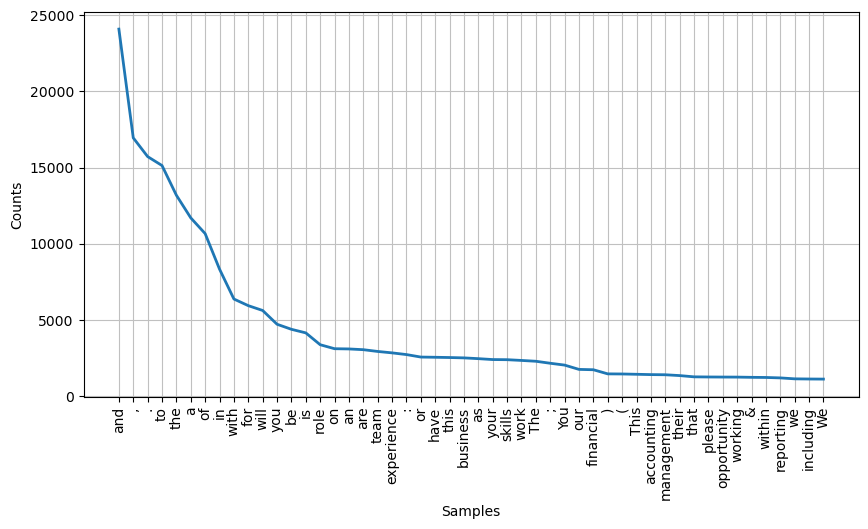

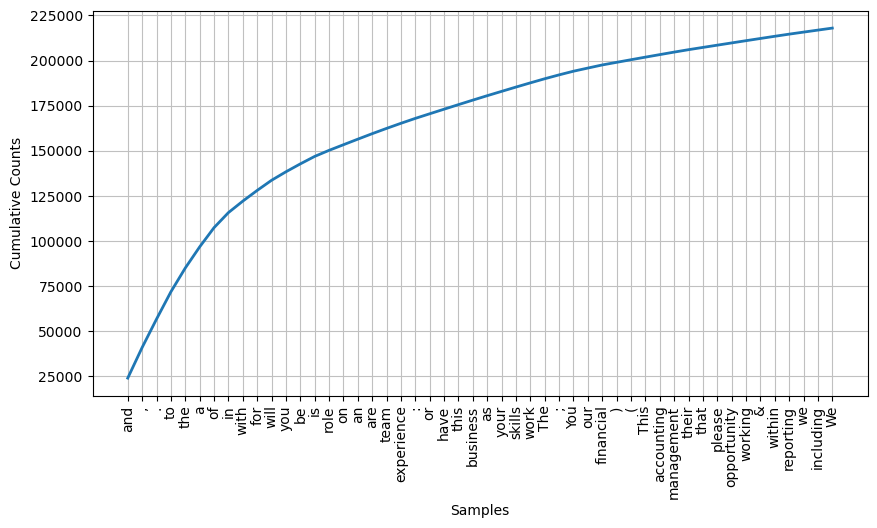

In [7]:
cate_des('Accounting')

### Data Prepreocessing

Since the function cannot display the results (charts) of each step in detail, I first use a small data set seek_dfm to demonstrate the data processing process for each step of Data Prepreocessing, and then write relevant functions for this step for the final summary and complete removal. After the stop word step, the function is used to traverse all job types and generate a json file.

#### Tokenize

In [163]:
# seek_df = pd.read_csv('clean.csv')

In [8]:
seek_dfm = seek_df.iloc[:100,:]

(1) Small data is used for display

In [10]:
import spacy
nlp = spacy.load('en_core_web_sm')

token_textm=[]
tokenize=[]
for i in tqdm(range(len(seek_dfm))):
    doc=nlp(str(seek_dfm['job_description'][i]))
    for token in doc:
        token_textm.append(token.text)
        tokenize.append(token)

100%|██████████| 100/100 [00:07<00:00, 13.48it/s]


(2) Tokenize function (please run)

In [11]:
import spacy
nlp = spacy.load('en_core_web_sm')

def jobdes_token(category):
    token_text=[]
    tokenize=[]
    for i in range(len(seek_df)):
        if seek_df['category'][i]==category:
            doc=nlp(str(seek_df['job_description'][i]))
            for token in doc:
                token_text.append(token.text)
                tokenize.append(token)
    size=len(set(tokenize))
    print('The jd size for '+ category+ ' after tokenized is', size)
    # print(len(set(token_text)))
    return token_text

In [12]:
token_text=jobdes_token('Accounting') # about 1m40s

The jd size for Accounting after tokenized is 536669


#### Lemmatize and compare with stemming

(1) Small data is used for display

In [13]:
from nltk.stem.wordnet import WordNetLemmatizer
jd_lemmed_m = [WordNetLemmatizer().lemmatize(w) for w in token_textm]

In [14]:
from nltk.stem.porter import PorterStemmer
jd_stemmed_m = [PorterStemmer().stem(w) for w in token_textm]

In [15]:
jd_cmp_m = pd.DataFrame({'Jd_token': token_textm, 'Jd_Lemmatize':jd_lemmed_m, 'Jd_Stemming':jd_stemmed_m}) 
jd_cmp_m[:22]

,Jd_token,Jd_Lemmatize,Jd_Stemming
0,,,
1,Have,Have,have
2,you,you,you
3,had,had,had
4,10,10,10
5,years,year,year
6,experience,experience,experi
7,in,in,in
8,fresh,fresh,fresh
9,produce,produce,produc


In [16]:
print('The vocabulary size for jd after lemmatize is ', len(set(jd_lemmed_m)))
print('The vocabulary size for jd after stemming is ', len(set(jd_stemmed_m)))

The vocabulary size for jd after lemmatize is  4780
The vocabulary size for jd after stemming is  3022


(2) Lemmatize and stemming function (please run)

In [17]:
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
def jobdes_lemstem(token_text):
    jd_lemmed = [WordNetLemmatizer().lemmatize(w) for w in token_text]
    jd_stemmed = [PorterStemmer().stem(w) for w in token_text]
    print('The vocabulary size for jd after lemmatize is ', len(set(jd_lemmed)))
    print('The vocabulary size for jd after stemming is ', len(set(jd_stemmed)))
    return(jd_lemmed)

In [18]:
jobdes_lemstem(token_text) # category == 'Accounting'

The vocabulary size for jd after lemmatize is  13642
The vocabulary size for jd after stemming is  8400


[' ',
 'Insolvency',
 'Intermediate',
 'or',
 'Senior',
 'Level',
 'Job',
 ',',
 'CBD',
 'Location',
 ',',
 'CA',
 'Firm',
 'Your',
 'new',
 'company',
 'Fantastic',
 'CA',
 'Practice',
 ',',
 'located',
 'in',
 'the',
 'centre',
 'of',
 'the',
 'CBD',
 'is',
 'seeking',
 'an',
 'intermediate',
 '/',
 'senior',
 'level',
 'insolvency',
 'accountant',
 'to',
 'join',
 'their',
 'dynamic',
 'and',
 'energetic',
 'environment',
 '.',
 'Your',
 'new',
 'role',
 'You',
 'will',
 'be',
 'working',
 'on',
 'a',
 'range',
 'of',
 'case',
 'and',
 'file',
 'for',
 'the',
 'firm',
 ',',
 'working',
 'alongside',
 'other',
 'intermediate',
 ',',
 'senior',
 'and',
 'manager',
 '.',
 'Your',
 'duty',
 'may',
 'include',
 'planning',
 'and',
 'control',
 'of',
 'fieldwork',
 'on',
 'smaller',
 'job',
 'with',
 'the',
 'direction',
 'of',
 'your',
 'supervisor',
 ',',
 'a',
 'well',
 'a',
 'liaising',
 'with',
 'the',
 'legal',
 'adviser',
 ',',
 'creditor',
 ',',
 'ASIC',
 'and',
 'other',
 'high',

#### Retokenize frequent noun phrases. 

(1) Small data is used for display

In [21]:
import spacy
nlp = spacy.load('en_core_web_sm')
jd_chunk_m = []
jd_chunk_m_type = []

for i in tqdm(range(len(seek_dfm))):
    jd_doc=nlp(str(seek_dfm['job_description'][i]))
    sent_chunk=[]
    sent_chunk_type=[]
    # Retokenize to treat each noun_chunk as a single token
    with jd_doc.retokenize() as retokenizer:  
        for chunk in jd_doc.noun_chunks:
            sent_chunk.append(chunk.text)
            sent_chunk_type.append(type(chunk))
        jd_chunk_m.append(sent_chunk)    
        jd_chunk_m_type.append(sent_chunk_type)
            # retokenizer.merge(chunk)
            #doc.retokenize().merge(chunk)


100%|██████████| 100/100 [00:07<00:00, 13.45it/s]


In [23]:
jd_chunk_m_df = pd.DataFrame({'chunk.text' : jd_chunk_m, 'chunk.type' : jd_chunk_m_type}) 
jd_chunk_m_df

,chunk.text,chunk.type
0,"[you, 10 years experience, fresh produce, thei...","[<class 'spacy.tokens.span.Span'>, <class 'spa..."
1,"[The Client Solution Analyst, technical suppor...","[<class 'spacy.tokens.span.Span'>, <class 'spa..."
2,"[An innovative business development role, an a...","[<class 'spacy.tokens.span.Span'>, <class 'spa..."
3,"[the role, We, an Automotive Workshop Technici...","[<class 'spacy.tokens.span.Span'>, <class 'spa..."
4,"[weekend, shifts, you, a great attitude, we, y...","[<class 'spacy.tokens.span.Span'>, <class 'spa..."
...,...,...
95,"[MinterEllison, we, pride, our clients' best p...","[<class 'spacy.tokens.span.Span'>, <class 'spa..."
96,"[ 8 weeks work, Heavy lifting, stock, Hard wor...","[<class 'spacy.tokens.span.Span'>, <class 'spa..."
97,"[ Business Analyst TELSTRA HEALTH, Our vision,...","[<class 'spacy.tokens.span.Span'>, <class 'spa..."
98,"[We, a highly motivated and talented Education...","[<class 'spacy.tokens.span.Span'>, <class 'spa..."


In [ ]:
# jd_chunk_m_count = jd_chunk_m_df['chunk.text'].value_counts().rename_axis('chunk.text').to_frame('n_chunk')
# jd_chunk_m_count[:50] #Noun phrases in the top 50 frequencies

(2) Retokenize function (please run)

In [52]:
def jobdes_retoken(category):
    jd_chunk = []
    jd_chunk_type = []
    for i in range(len(seek_df)):
        if seek_df['category'][i]==category:
            jd_doc=nlp(str(seek_df['job_description'][i]))
            sent_chunk=[]
            sent_chunk_type=[]
            with jd_doc.retokenize() as retokenizer:  
                for chunk in jd_doc.noun_chunks:
                    sent_chunk.append(chunk.text)
                    sent_chunk_type.append(type(chunk))
                jd_chunk.append(sent_chunk)    
                jd_chunk_type.append(sent_chunk_type)
    n=0
    for i in range(len(jd_chunk)):
        j=len(jd_chunk[i])
        n=n+j
    print('The jd size for '+ category+' after retokenize is ', n)
    return(jd_chunk)

In [53]:
jd_c=jobdes_retoken('Accounting') # about 1m20s

The jd size for Accounting after retokenize is  126813


#### Remove stop words (rank words according to TF/IDF).

##### (1) The small data set display part uses the TfidfVectorizer method to remove stop words

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords 

In [29]:
jd_list_m = []

for i in tqdm(range(len(seek_dfm))):
	jd_list_m.append(str(seek_dfm['job_description'][i]))


100%|██████████| 100/100 [00:00<00:00, 50472.97it/s]


In [30]:
stop_words = list(stopwords.words('english'))


In [ ]:
# if ',' in stop_words:
#     print('y')

TfidfVectorizer can convert the original text into the feature matrix of tf-idf, so as to calculate the similarity of the subsequent text

TfidfVectorizer considers the word document frequency when constructing the vocabulary (feature vocabulary), and can select min_df and max_df to achieve feature selection by document frequency.
When set to a floating point number, the words appearing in the sentences that exceed the max_df/lower than min_df ratio are filtered; when a positive integer, the sentences that exceed the max_df are filtered. Generally filter words that appear in more than 60% of sentences, max_df=0.6

In [32]:
tfidf_vectorizer = TfidfVectorizer()
tfidf = TfidfVectorizer(analyzer='word', stop_words = 'english',max_df=.60)
jd_tfidf_m = tfidf.fit_transform(jd_list_m)

# get_feature_names is deprecated in 1.0 and will be removed in 1.2. 
# Please use get_feature_names_out instead.
terms = tfidf.get_feature_names()
# terms = tfidf.get_feature_names_out()


# sum tfidf frequency of each term through documents
jd_sums_m = jd_tfidf_m.sum(axis=0)

# connecting term to its sums frequency
data_m = []
for col, term in enumerate(terms):
    data_m.append( (term, jd_sums_m[0,col] ))
rank_m = pd.DataFrame(data_m, columns=['term','rank'])
rank_m = rank_m.sort_values('rank', ascending=False)
rank_m.index = range(len(data_m))
rank_m


,term,rank
0,service,3.239995
1,management,2.954280
2,customer,2.901791
3,ability,2.800248
4,business,2.791206
...,...,...
3912,rec,0.032696
3913,matching,0.032696
3914,recommended,0.032696
3915,herts,0.032696


In [34]:
jd_stop_m = stop_words
for i in range(len(rank_m)):   
    jd_stop_m.append(rank_m['term'][i])
jd_filtered_m = [w for w in token_text if w not in jd_stop_m] 

In [35]:
print('The vocabulary size for job description after remove stop words is ', len(jd_filtered_m))

The vocabulary size for job description after remove stop words is  193295


##### （2）Remove stop words function(please run), uses the TfidfModel method in gensim

In [36]:
import gensim
from gensim import corpora
from gensim import models
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from nltk.corpus import stopwords

In [37]:
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) 

In [38]:
def jobdes_remove(retokenize_list):
    overall_lst=[]
    overall_stop=[]
    stopword_count=[]
    total=[]
    overall=[]
    for i in range(len(retokenize_list)):
        lst= retokenize_list[i]
        lst_sentence=''
        for j in lst:
            lst_sentence += j + " "
        overall_lst.append(lst_sentence)
    doc_tokenized=list(sent_to_words(overall_lst))
    dictionary = Dictionary()
    BoW_corpus=[dictionary.doc2bow(doc,allow_update=True) for doc in doc_tokenized]
    tfidf = TfidfModel(BoW_corpus,smartirs='ntc')
    for doc in tfidf[BoW_corpus]:
        token_lst=[]
        for id, freq in doc:
            token_lst.append([dictionary[id],np.around(freq,decimals=8)])
            token_lst.sort(key=lambda x:x[1])
            stopword = [x for x, y in token_lst[:15]] # each
        overall_stop.append(stopword)
    for word in overall_stop:
        stopword_count.append(stopword)
    top10tfidf = pd.value_counts(stopword_count)
    top10_list = top10tfidf.index.tolist()[:10]
    stwo_in_official=[word for word in top10_list if not word in stopwords.words()]
    for p in range(len(retokenize_list)):
        new_list=[word for word in retokenize_list[p] if not word in stwo_in_official]
        total.append(new_list)
    for l in total:
        overall += l
    text_size = len(overall)
    voc_size=len(set(overall))
    size= (text_size,voc_size)
    print('The vocabulary size for job description after remove stop words is ', size)
    return size, total


In [39]:
jobdes_remove(jd_chunk)

The vocabulary size for job description after remove stop words is  (8122, 5213)


((8122, 5213),
 [['you',
   '10 years experience',
   'fresh produce',
   'their own store',
   'a family owned Australian company',
   'food',
   'We',
   '10+ years',
   'the fresh food business',
   'the passion',
   'the role',
   'Current 2IC',
   'training',
   'Store manager role',
   'Excellent customer service',
   'communication skills',
   'hands',
   'attitude',
   'the fresh food business',
   'the passion',
   'the role',
   'Hardworking, ambitious and competitive people',
   'who',
   'good food',
   'the financial return',
   'their market',
   'it',
   'sales',
   'margin and wages budgets',
   'exceptional merchandising capabilities',
   'customer service skills',
   'us',
   'unique shopping experiences',
   'our customers',
   'a wealth',
   'knowledge',
   'fresh food retailing',
   'a willingness',
   'this knowledge',
   'a teams',
   'early starts',
   'what fresh produce',
   'What',
   'it',
   'you',
   '$100 K',
   'super',
   '+',
   'Fun and challenging wo

In [40]:
size_remove, SWord_Removed = jobdes_remove(jd_chunk)

The vocabulary size for job description after remove stop words is  (8122, 5213)


#### Combine all Data Prepreocessing functions, go through each category and append the processed output to a new datafram(csv) (about 40m)

In [54]:
total_df = pd.DataFrame()
category_lst = np.unique(seek_df['category'].tolist())
for i in tqdm(range(len(category_lst))):
    tokenize = jobdes_token(category_lst[i])
    word=jobdes_lemstem(tokenize)
    jd_chunk=jobdes_retoken(category_lst[i])
    size, SWord_Removed= jobdes_remove(jd_chunk)
    whole_df=seek_df[seek_df['category']==category_lst[i]]
    new_df = whole_df
    newcol=[]
    for p in SWord_Removed:
        new_lin=''
        for q in p:
            new_lin += q +" "
        newcol.append(new_lin)
    new_df['job_description']= newcol
    total_df=pd.concat([total_df,new_df])
total_df

  0%|          | 0/30 [00:00<?, ?it/s]

The jd size for Accounting after tokenized is 536669
The vocabulary size for jd after lemmatize is  13642
The vocabulary size for jd after stemming is  8400
The jd size for Accounting after retokenize is  126813


<ipython-input-54-6eb7ac7a0daa>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['job_description']= newcol
  3%|▎         | 1/30 [02:18<1:06:49, 138.26s/it]

The vocabulary size for job description after remove stop words is  (126813, 41447)
The jd size for Administration & Office Support after tokenized is 566297
The vocabulary size for jd after lemmatize is  16398
The vocabulary size for jd after stemming is  10084
The jd size for Administration & Office Support after retokenize is  133905


  7%|▋         | 2/30 [04:44<1:06:40, 142.86s/it]

The vocabulary size for job description after remove stop words is  (133905, 48296)
The jd size for Advertising, Arts & Media after tokenized is 57582
The vocabulary size for jd after lemmatize is  5260
The vocabulary size for jd after stemming is  3335
The jd size for Advertising, Arts & Media after retokenize is  13722


 10%|█         | 3/30 [04:59<38:08, 84.75s/it]   

The vocabulary size for job description after remove stop words is  (13722, 7259)
The jd size for Banking & Financial Services after tokenized is 262947
The vocabulary size for jd after lemmatize is  9256
The vocabulary size for jd after stemming is  5418
The jd size for Banking & Financial Services after retokenize is  63382


 13%|█▎        | 4/30 [06:07<33:42, 77.77s/it]

The vocabulary size for job description after remove stop words is  (63382, 22711)
The jd size for CEO & General Management after tokenized is 37071
The vocabulary size for jd after lemmatize is  4347
The vocabulary size for jd after stemming is  2784
The jd size for CEO & General Management after retokenize is  8650


 17%|█▋        | 5/30 [06:17<22:13, 53.34s/it]

The vocabulary size for job description after remove stop words is  (8650, 5204)
The jd size for Call Centre & Customer Service after tokenized is 248687
The vocabulary size for jd after lemmatize is  10128
The vocabulary size for jd after stemming is  5970
The jd size for Call Centre & Customer Service after retokenize is  58318


 20%|██        | 6/30 [07:20<22:46, 56.95s/it]

The vocabulary size for job description after remove stop words is  (58318, 21998)
The jd size for Community Services & Development after tokenized is 405719
The vocabulary size for jd after lemmatize is  10894
The vocabulary size for jd after stemming is  6910
The jd size for Community Services & Development after retokenize is  98733


 23%|██▎       | 7/30 [09:04<27:38, 72.09s/it]

The vocabulary size for job description after remove stop words is  (98733, 24733)
The jd size for Construction after tokenized is 365983
The vocabulary size for jd after lemmatize is  12921
The vocabulary size for jd after stemming is  7761
The jd size for Construction after retokenize is  86414


 27%|██▋       | 8/30 [10:40<29:11, 79.63s/it]

The vocabulary size for job description after remove stop words is  (86414, 33012)
The jd size for Consulting & Strategy after tokenized is 76544
The vocabulary size for jd after lemmatize is  5490
The vocabulary size for jd after stemming is  3358
The jd size for Consulting & Strategy after retokenize is  18840


 30%|███       | 9/30 [10:59<21:16, 60.80s/it]

The vocabulary size for job description after remove stop words is  (18840, 8548)
The jd size for Design & Architecture after tokenized is 94595
The vocabulary size for jd after lemmatize is  6351
The vocabulary size for jd after stemming is  3924
The jd size for Design & Architecture after retokenize is  22429


 33%|███▎      | 10/30 [11:24<16:32, 49.65s/it]

The vocabulary size for job description after remove stop words is  (22429, 10785)
The jd size for Education & Training after tokenized is 609009
The vocabulary size for jd after lemmatize is  15471
The vocabulary size for jd after stemming is  9992
The jd size for Education & Training after retokenize is  146356


 37%|███▋      | 11/30 [13:58<25:54, 81.83s/it]

The vocabulary size for job description after remove stop words is  (146356, 38768)
The jd size for Engineering after tokenized is 304271
The vocabulary size for jd after lemmatize is  12028
The vocabulary size for jd after stemming is  7371
The jd size for Engineering after retokenize is  73063


 40%|████      | 12/30 [15:17<24:14, 80.81s/it]

The vocabulary size for job description after remove stop words is  (73063, 29075)
The jd size for Farming, Animals & Conservation after tokenized is 33252
The vocabulary size for jd after lemmatize is  4465
The vocabulary size for jd after stemming is  2876
The jd size for Farming, Animals & Conservation after retokenize is  7819


 43%|████▎     | 13/30 [15:26<16:43, 59.03s/it]

The vocabulary size for job description after remove stop words is  (7819, 4773)
The jd size for Government & Defence after tokenized is 596262
The vocabulary size for jd after lemmatize is  14936
The vocabulary size for jd after stemming is  9806
The jd size for Government & Defence after retokenize is  144470


 47%|████▋     | 14/30 [17:56<23:06, 86.68s/it]

The vocabulary size for job description after remove stop words is  (144470, 34536)
The jd size for Healthcare & Medical after tokenized is 832248
The vocabulary size for jd after lemmatize is  19523
The vocabulary size for jd after stemming is  12851
The jd size for Healthcare & Medical after retokenize is  196482


 50%|█████     | 15/30 [21:30<31:15, 125.03s/it]

The vocabulary size for job description after remove stop words is  (196482, 56822)
The jd size for Hospitality & Tourism after tokenized is 358189
The vocabulary size for jd after lemmatize is  13077
The vocabulary size for jd after stemming is  7789
The jd size for Hospitality & Tourism after retokenize is  84004


 53%|█████▎    | 16/30 [23:05<27:02, 115.86s/it]

The vocabulary size for job description after remove stop words is  (84004, 30638)
The jd size for Human Resources & Recruitment after tokenized is 273932
The vocabulary size for jd after lemmatize is  10178
The vocabulary size for jd after stemming is  6215
The jd size for Human Resources & Recruitment after retokenize is  65844


 57%|█████▋    | 17/30 [24:15<22:05, 101.98s/it]

The vocabulary size for job description after remove stop words is  (65844, 24312)
The jd size for Information & Communication Technology after tokenized is 971938
The vocabulary size for jd after lemmatize is  21607
The vocabulary size for jd after stemming is  13510
The jd size for Information & Communication Technology after retokenize is  233104


 60%|██████    | 18/30 [28:20<29:02, 145.23s/it]

The vocabulary size for job description after remove stop words is  (233104, 77930)
The jd size for Insurance & Superannuation after tokenized is 91956
The vocabulary size for jd after lemmatize is  5083
The vocabulary size for jd after stemming is  2969
The jd size for Insurance & Superannuation after retokenize is  22215


 63%|██████▎   | 19/30 [28:44<19:56, 108.74s/it]

The vocabulary size for job description after remove stop words is  (22215, 8210)
The jd size for Legal after tokenized is 168222
The vocabulary size for jd after lemmatize is  7749
The vocabulary size for jd after stemming is  4805
The jd size for Legal after retokenize is  39296


 67%|██████▋   | 20/30 [29:27<14:50, 89.08s/it] 

The vocabulary size for job description after remove stop words is  (39296, 15287)
The jd size for Manufacturing, Transport & Logistics after tokenized is 578835
The vocabulary size for jd after lemmatize is  17312
The vocabulary size for jd after stemming is  10471
The jd size for Manufacturing, Transport & Logistics after retokenize is  133461


 70%|███████   | 21/30 [31:58<16:07, 107.47s/it]

The vocabulary size for job description after remove stop words is  (133461, 48817)
The jd size for Marketing & Communications after tokenized is 282615
The vocabulary size for jd after lemmatize is  11317
The vocabulary size for jd after stemming is  6856
The jd size for Marketing & Communications after retokenize is  68047


 73%|███████▎  | 22/30 [33:10<12:55, 96.93s/it] 

The vocabulary size for job description after remove stop words is  (68047, 28166)
The jd size for Mining, Resources & Energy after tokenized is 294451
The vocabulary size for jd after lemmatize is  10827
The vocabulary size for jd after stemming is  6488
The jd size for Mining, Resources & Energy after retokenize is  68844


 77%|███████▋  | 23/30 [34:26<10:34, 90.68s/it]

The vocabulary size for job description after remove stop words is  (68844, 24244)
The jd size for Real Estate & Property after tokenized is 183804
The vocabulary size for jd after lemmatize is  8230
The vocabulary size for jd after stemming is  4850
The jd size for Real Estate & Property after retokenize is  43781


 80%|████████  | 24/30 [35:14<07:45, 77.65s/it]

The vocabulary size for job description after remove stop words is  (43781, 17783)
The jd size for Retail & Consumer Products after tokenized is 322758
The vocabulary size for jd after lemmatize is  10886
The vocabulary size for jd after stemming is  6369
The jd size for Retail & Consumer Products after retokenize is  76907


 83%|████████▎ | 25/30 [36:36<06:35, 79.11s/it]

The vocabulary size for job description after remove stop words is  (76907, 22704)
The jd size for Sales after tokenized is 520381
The vocabulary size for jd after lemmatize is  15308
The vocabulary size for jd after stemming is  9079
The jd size for Sales after retokenize is  122337


 87%|████████▋ | 26/30 [38:49<06:20, 95.21s/it]

The vocabulary size for job description after remove stop words is  (122337, 44052)
The jd size for Science & Technology after tokenized is 62703
The vocabulary size for jd after lemmatize is  5961
The vocabulary size for jd after stemming is  3757
The jd size for Science & Technology after retokenize is  15172


 90%|█████████ | 27/30 [39:05<03:34, 71.45s/it]

The vocabulary size for job description after remove stop words is  (15172, 8255)
The jd size for Self Employment after tokenized is 4757
The vocabulary size for jd after lemmatize is  1036
The vocabulary size for jd after stemming is  818


 93%|█████████▎| 28/30 [39:06<01:40, 50.44s/it]

The jd size for Self Employment after retokenize is  1076
The vocabulary size for job description after remove stop words is  (1076, 535)
The jd size for Sport & Recreation after tokenized is 50665
The vocabulary size for jd after lemmatize is  4513
The vocabulary size for jd after stemming is  2804
The jd size for Sport & Recreation after retokenize is  12049


 97%|█████████▋| 29/30 [39:20<00:39, 39.30s/it]

The vocabulary size for job description after remove stop words is  (12049, 5521)
The jd size for Trades & Services after tokenized is 795012
The vocabulary size for jd after lemmatize is  21313
The vocabulary size for jd after stemming is  13170
The jd size for Trades & Services after retokenize is  184969


100%|██████████| 30/30 [42:49<00:00, 85.64s/it]

The vocabulary size for job description after remove stop words is  (184969, 62260)


,Unnamed: 0,category,city,company_name,geo,job_board,job_description,job_title,job_type,post_date,salary_offered,state,url
42,42,Accounting,Sydney,Hays Accountancy & Finance,AU,seek,Insolvency Intermediate or Senior Level Job C...,Insolvency Intermediate/Senior,Full Time,2018-04-16T01:33:59Z,NaN,"CBD, Inner West & Eastern Suburbs",https://www.seek.com.au/job/35991750
45,45,Accounting,Sydney,EML,AU,seek,Sydney CBD office Great Opportunity career pr...,Asset & Contracts Manager,Full Time,2018-04-16T04:00:02Z,NaN,NaN,https://www.seek.com.au/job/35993987
82,82,Accounting,Sydney,Robert Half Finance & Accounting,AU,seek,We a Global FMCG organisation an exciting 6 mo...,Credit Officer,Contract/Temp,2018-04-16T02:41:24Z,$28 - $32 p.h.,Ryde & Macquarie Park,https://www.seek.com.au/job/35992747
92,92,Accounting,Brisbane,Hays Accountancy & Finance,AU,seek,This progressive business a skilled & accurate...,Finance Officer,Full Time,2018-04-16T03:12:55Z,NaN,Northern Suburbs,https://www.seek.com.au/job/35993171
123,123,Accounting,Melbourne,CFA,AU,seek,The Country Fire Authority (CFA the world's la...,Business Support Officer Accounts Receivable,Full Time,2018-04-16T02:38:21Z,NaN,Bayside & South Eastern Suburbs,https://www.seek.com.au/job/35992698
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29972,29972,Trades & Services,Yarra Valley & High Country,Hitech Steel,AU,seek,We an experience tradesman who the skills draw...,boilermaker / sheet metal worker,Full Time,2018-04-11T04:21:08Z,"$50,000 - $69,999",NaN,https://www.seek.com.au/job/35958508
29976,29976,Trades & Services,Melbourne,Silver Star Motors,AU,seek,you your next challenge you an award winning t...,Automotive Technician,Full Time,2018-04-11T05:13:26Z,NaN,Eastern Suburbs,https://www.seek.com.au/job/35959523
29983,29983,Trades & Services,Brisbane,Hays Manufacturing & Operations,AU,seek,Sheet Metal job the western suburbs Brisbane ...,Sheet Metal Worker,Contract/Temp,2018-04-11T03:39:07Z,NaN,Southern Suburbs & Logan,https://www.seek.com.au/job/35957691
29989,29989,Trades & Services,Melbourne,Defence Force Recruiting Southern Region,AU,seek,The professional footy player tactics effectiv...,Infantry Soldier - Female Opportunity,Full Time,2018-04-11T02:28:13Z,NaN,Western Suburbs,https://www.seek.com.au/job/35956735


#### Group job descriptions in the corpus, use TF/IDF to rank noun phrases and named entities, build a list for job title, location, company name, field of experience.

In [57]:
# Load a spacy model and chekc if it has ner
import spacy
nlp=spacy.load('en_core_web_sm')

nlp.pipe_names

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']

In [177]:
# doc=nlp(jd_str)
# for ent in doc.ents:
#   print(ent.text,ent.label_)

#### Train new ner to identify experience requirement (Update Named Entity Recognizer)

In [58]:
# Import and load the spacy model
import spacy
nlp=spacy.load("en_core_web_sm") 

# Getting the ner component
ner=nlp.get_pipe('ner')

Format of training examples

In [59]:
# New label to add
LABEL = "EXPERIENCE"

# Training examples in the required format
TRAIN_DATA =[ ("Minimum of 3 years experience in a senior planner role being able to demonstrate client retention over a sustained period of time.", {"entities": [(11, 28, "EXPERIENCE")]}),
              ("You have experience in writing content and adjusting websites via CMS systems", {"entities": [(4, 18, "EXPERIENCE")]}),
              ("Qualifications in relevant discipline such as business or computing Demonstrated experience in a Service Desk function Relevant professional qualifications in ITIL practices and/or other applicable audit or industry standards (desirable) Practical experience in ITSM approach (desirable)", {"entities": [(262,287, "EXPERIENCE")]}),
              ("The ideal applicant will have a current electrical license with experience in a related field", {"entities": [(25,36, "EXPERIENCE")]}),
              ("You will have a Mechanical Trade Certificate and mechanical experience including servicing and diagnostics gained in any mechanical industry. ", {"entities": [(9,69, "EXPERIENCE")]}),
              ("No experience necessary as long as you have a great attitude we will teach you great skills.", {"entities": [(0,14, "EXPERIENCE")]}),
              ("Have you had 10 years experience in fresh produce that wants to manage their own store for a family owned Australian company that is passionate about food.", {"entities": [(9,32, "EXPERIENCE")]}),
              ("Demonstrated experience in Quality Management Systems â€¢Â Extensive knowledge of the blood and tissue code of GMP or similar codes", {"entities": [(13,53, "EXPERIENCE")]}),
              ("Ideally you will also possess: 4+ years' experience as an Account Manager within a mass retail environment, with FMCG and category management experience.", {"entities": [(31,51, "EXPERIENCE")]}),
              ("or Demonstrated experience in working with children and/or families in relation to complex issues", {"entities": [(16,67, "EXPERIENCE")]}),
              ("An exciting opportunity currently exists for an enthusiastic and experienced", {"entities": [(65,76, "EXPERIENCE")]}),
              ("manuals and IT policies Requirements 4-8 years proven experience as a System Administrator", {"entities": [(37,64, "EXPERIENCE")]}),
              ("Qualifications are not essential but experience in spray painting in a professional environment is required", {"entities": [(37,65, "EXPERIENCE")]}),
              ("aturday Be Reliable and Punctual Have own reliable transportation Be available to commence ASAP Previous experience using plant machinery On offer is excellent pay rates, chance to go permanent with the client, ongoing work, great team and management, good working conditions and the chance to advance", {"entities": [(105,137, "EXPERIENCE")]}),
              ("Access Control Experience in running multi projects.", {"entities": [(15,51, "EXPERIENCE")]}),
              ("We are interested to hear from experienced medical device representatives.", {"entities": [(31,73, "EXPERIENCE")]}),
              ("Have all relevant licenses You MUST have experience on and are able to work unaided with:", {"entities": [(41,83, "EXPERIENCE")]}),
              ("Demonstrated experience in operations planning in a fast-paced environment Specific industry experience would be highly advantageous", {"entities": [(13,46, "EXPERIENCE")]})
           ]

           
           

In [60]:
# Add the new label to ner
ner.add_label(LABEL)

# Resume training
optimizer = nlp.resume_training()
move_names = list(ner.move_names)

# List of pipes you want to train
pipe_exceptions = ["ner", "trf_wordpiecer", "trf_tok2vec"]

# List of pipes which should remain unaffected in training
other_pipes = [pipe for pipe in nlp.pipe_names if pipe not in pipe_exceptions]

In [62]:
# Importing requirements
from spacy.util import minibatch, compounding
from spacy.training.example import Example
import random

# Begin training by disabling other pipeline components
with nlp.disable_pipes(*other_pipes) :

  sizes = compounding(1.0, 4.0, 1.001)
  # Training for 30 iterations     
  for itn in range(30):
    # shuffle examples before training
    random.shuffle(TRAIN_DATA)
    # batch up the examples using spaCy's minibatch
    batches = minibatch(TRAIN_DATA, size=sizes)
    # ictionary to store losses
    losses = {}
    for batch in spacy.util.minibatch(TRAIN_DATA, size=2):
        for text, annotations in batch:
            # create Example
            doc = nlp.make_doc(text)
            example = Example.from_dict(doc, annotations)
            # Update the model
            nlp.update([example], losses=losses, drop=0.3)
            print("Losses", losses)


Losses {'ner': 2.768507335150362e-11}
Losses {'ner': 0.00018449787461297373}
Losses {'ner': 0.00018450741041388434}
Losses {'ner': 0.00018451832742008347}
Losses {'ner': 0.00018452913957854543}
Losses {'ner': 0.00018471082128530554}
Losses {'ner': 0.0001847108221601111}
Losses {'ner': 0.0001847108232861558}
Losses {'ner': 0.0001847108241990652}
Losses {'ner': 0.00019139120973957479}
Losses {'ner': 0.0001915279829439618}
Losses {'ner': 0.00019196626499636582}
Losses {'ner': 0.00021286003987608517}
Losses {'ner': 0.00021286249721822227}
Losses {'ner': 0.0002128688225318062}
Losses {'ner': 0.0002949203476191253}
Losses {'ner': 0.0002949203476434828}
Losses {'ner': 0.0002965342882657082}
Losses {'ner': 6.342773319157711e-09}
Losses {'ner': 0.0018555265730379128}
Losses {'ner': 0.0018555265785188198}
Losses {'ner': 0.0018555266516359626}
Losses {'ner': 0.0018574853895545218}
Losses {'ner': 0.0018574877700881622}
Losses {'ner': 0.0018574878251250944}
Losses {'ner': 0.0018577475874924925}
Los

In [63]:
# Testing the NER

test_text=seek_df['job_description'][0]
doc = nlp(test_text)

for ent in doc.ents:
  print(ent)

had 10 years experience
10+ years
use to early starts
100


####  build a list each for job names, locations, company names, areas of experience to check if this line have all those conditions

In [64]:
jt_list=[] # job names
loc_list=[] # locations
cn_list =[] # company names
jtype_list=[] # full time/part time/casual,
exp_list = [] # areas of experience

for i in tqdm(range(len(seek_df))):
    label_list=[]
    doc=nlp(str(seek_df['job_description'][i]))
    for ent in doc.ents:
        label_list.append(ent.label_)
    jt_list.append(1) if seek_df['job_title'][i] is not None else jt_list.append(0)
    loc_list.append(1) if seek_df['city'][i] is not None  else loc_list.append(0)
    cn_list.append(1) if seek_df['company_name'][i] is not None else cn_list.append(0)
    jtype_list.append(1) if seek_df['job_type'][i] is not None else jtype_list.append(0)
    exp_list.append(1) if ('EXPERIENCE' in label_list) or ('experience' in str(seek_df['job_description'][i])) else exp_list.append(0)
    

100%|██████████| 30000/30000 [19:48<00:00, 25.23it/s]


In [65]:
dic={"job names":jt_list,"locations":loc_list,'company names':cn_list,'job type':jtype_list,'areas of experience':exp_list}
jd_first_text=pd.DataFrame(dic)
jd_first_text

,job names,locations,company names,job type,areas of experience
0,1,1,1,1,1
1,1,1,1,1,1
2,1,1,1,1,1
3,1,1,1,1,1
4,1,1,1,1,1
...,...,...,...,...,...
29995,1,1,1,1,1
29996,1,1,1,1,1
29997,1,1,1,1,1
29998,1,1,1,1,1


In [ ]:
# seek_df = pd.read_csv('clean.csv')

This part needs to traverse the whole table, which takes a long time(about 20m). The result from this step to the exported json file is seek_df.json, which can be used directly in the chat robot part.

In [66]:
expp=[]
for i in tqdm(range(len(seek_df))):
  lab=[]
  exp=[]
  doc=nlp(str(seek_df['job_description'][i]))
  for ent in doc.ents:
    lab.append(ent.label_)
    if ('EXPERIENCE' in lab):
      # print(ent)
      exp.append(ent)
  expp.append(exp)


100%|██████████| 30000/30000 [19:53<00:00, 25.13it/s]


In [67]:
expp
# name=['experience_required']
# test = pd.DataFrame(columns=name,data=expp)
# test.to_csv("expp.csv")

[[had 10 years experience, 10+ years, use to early starts, 100],
 [Experience Demonstrated experience,
  ITSM approach (desirable),
  8:00am 24 April 2018.],
 [BHP and McDonalds, Australia's leading],
 [],
 [],
 [experience in Quality Management Systems, (03) 9006 1806., Monday, 30],
 [thrives on working in a fast-paced,
  4+ years' experience,
  03 9263 5688.,
  www.yates.com.au and explore],
 [experience in working with children and/or families,
  experience in working with children and/or families,
  104 and 105,
  Queensland Provisional Green,
  30th April 2018,
  9am.],
 [experienced],
 [4-8 years proven experience,
  Experience with Desktop, Mobile,
  02 9259 8761 M&T Resources,
  Australia's most],
 [experienced, experience in spray painting],
 [experience in operations planning],
 [experience  Cleaning copper Load, experience using plant machinery],
 [DIY to Commercial projects, Crestmead, Brisbane],
 [CCTV , Access Control,
  Experience in running multi projects,
  experience 

#### Parse each job description, potentially using the dictionary above to create a json object for each job with the detected entities.

In order to prevent the correct json file from being output due to insufficient time to run, the display of this step is exported as seek_df1.json file. 
If fully run, there is no difference between seek_df1.json and seek_df.json. 

I have submitted the seek_df.json file along with the compressed package and can be used directly. 

In [68]:
import json
d=[]
for i in range(len(seek_df)):
    d.append({
        'category': seek_df['category'][i],
        'job title': seek_df['job_title'][i],
        'locations': seek_df['city'][i],
        'company names':seek_df['company_name'][i],
        'job type': seek_df['job_type'][i],
        'areas of experience' : str(expp[i]),
        # 'job description' : seek_df['job_description'][i]
    })
    
# with open('seek_df.json', 'w',encoding='utf-8') as json_file:
#     json.dump(d,json_file,ensure_ascii=False)
with open('seek_df1.json', 'w',encoding='utf-8') as json_file:
    json.dump(d,json_file,ensure_ascii=False)

There is no difference between seek_df1.json and seek_df.json if time is long enough to run completely.

In [69]:
# Load json file and convert it as a data frame
with open('seek_df.json') as f:
    data = json.load(f)
    df = pd.json_normalize(data)
df

,category,job title,locations,company names,job type,areas of experience
0,Retail & Consumer Products,Store Manager - Fresh Produce,Sydney,Frontline Executive Retail Sydney,Full Time,"[had 10 years experience, 10+ years in the fre..."
1,Government & Defence,Client Solution Analyst,Brisbane,Powerlink,Full Time,"[the on call roster, experience working within..."
2,Trades & Services,Service Technician / Installer - NSW,Sydney,Richard Jay Laundry,Full Time,"[the Hilton Group, the Royal Adelaide Hospital]"
3,Trades & Services,Workshop Technician I Material Handling Equipment,Melbourne,Adaptalift Hyster,Full Time,[]
4,Trades & Services,APPRENTICESHIP JUNIOR BAKER,Adelaide,Bakers Delight G&M,Full Time,[]
...,...,...,...,...,...,...
29995,Hospitality & Tourism,Bar Supervisor,Sydney,Radisson Blu Plaza Hotel Sydney,Full Time,"[Experience with people management, 2 day Orie..."
29996,CEO & General Management,Deputy Board Secretary,ACT,Airservices Australia,Full Time,"[11 per cent, 26 Australian airports, Experien..."
29997,Accounting,Corporate Accountant,Melbourne,The Hassett Group,Full Time,"[experienced, Prepare the ASX reporting and as..."
29998,Government & Defence,APS 6 & EL1 Account Managers,ACT,SOS Recruitment,Contract/Temp,[]


In [70]:
# Load json file and convert it as a data frame
with open('seek_df1.json') as f:
    data = json.load(f)
    df1 = pd.json_normalize(data)
df1

,category,job title,locations,company names,job type,areas of experience
0,Retail & Consumer Products,Store Manager - Fresh Produce,Sydney,Frontline Executive Retail Sydney,Full Time,"[had 10 years experience, 10+ years, use to ea..."
1,Government & Defence,Client Solution Analyst,Brisbane,Powerlink,Full Time,"[Experience Demonstrated experience, ITSM appr..."
2,Trades & Services,Service Technician / Installer - NSW,Sydney,Richard Jay Laundry,Full Time,"[BHP and McDonalds, Australia's leading]"
3,Trades & Services,Workshop Technician I Material Handling Equipment,Melbourne,Adaptalift Hyster,Full Time,[]
4,Trades & Services,APPRENTICESHIP JUNIOR BAKER,Adelaide,Bakers Delight G&M,Full Time,[]
...,...,...,...,...,...,...
29995,Hospitality & Tourism,Bar Supervisor,Sydney,Radisson Blu Plaza Hotel Sydney,Full Time,"[Experience with people management, 2 day Orie..."
29996,CEO & General Management,Deputy Board Secretary,ACT,Airservices Australia,Full Time,"[Melbourne and Brisbane, experience in governa..."
29997,Accounting,Corporate Accountant,Melbourne,The Hassett Group,Full Time,"[Experience in audit, preferably]"
29998,Government & Defence,APS 6 & EL1 Account Managers,ACT,SOS Recruitment,Contract/Temp,[]


This step has also been completed in advance, and the new csv file (seek.csv) for future use by the chatbot generated in the Data Prepreocessing section has been uploaded with the zip

In [ ]:
# df.to_csv('seek.csv')

In [ ]:
df1.to_csv('seek1.csv')

### Linguistic Patterns

#### Design linguistic patterns to parse user input, two patterns for each of the above entities. 

In [71]:
import spacy
import random
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

In [72]:
def dep(doc):
    dep = [token.dep_ for token in doc]
    return dep

In [73]:
import spacy
from spacy.matcher import Matcher
nlp = spacy.load("en_core_web_sm")
matcher = Matcher(nlp.vocab)

def pattern_matcher(doc):
    doc = nlp(doc)
    matches = matcher(doc)
    for match_id, start, end in matches:
        span = doc[start:end]
        print("Span: ", span.text)
        print("The positions in the doc are: ", start, "-", end)
        print("Match ID ", match_id)
        print(doc.vocab.strings[match_id],'\n') 

##### job category, job name,

In [74]:
jt_pattern = [ #[{"DEP": "compound"},{"DEP":"dobj"}],
                [{"LEMMA":"for"},{"DEP": "pobj"}], 
                [{"DEP": "compound"},{"DEP":"pobj"}],
                [{"DEP": "amod"},{"DEP": "compound"},{"DEP":"dobj"}],
                [{"DEP": "compound"},{"DEP":"compound"},{"DEP":"pobj"}],
                [{"DEP": "det"},{"DEP":"pobj"}],
                ]
matcher.add("job title", jt_pattern) 

##### location,

In [75]:
loc_pattern = [[{"LEMMA": "in"}, {"DEP":"pobj"}], 
                [{"LEMMA": "in"},{"DEP":"pobj"},{"LEMMA": "city"}]
                ]
matcher.add("location", loc_pattern) 

##### company name,

In [76]:
cn_pattern = [[{"DEP": "compound"},{"DEP":"nsubj"}], 
                [{"DEP": "amod"},{"DEP":"nsubj"}],
                [{"DEP": "compound"},{"LEMMA": "company", "POS": "NOUN"}]
                ]
matcher.add("company name", cn_pattern)

##### full time/part time/casual,

In [77]:
jtype_pattern = [[{"TEXT": "Full"},{"TEXT": "Time"}], [{"TEXT": "Part"},{"TEXT": "Time"}],[{"TEXT": "full"},{"TEXT": "time"}],
                [{"TEXT": "Full"},{"TEXT": "time"}],[{"TEXT": "part"},{"TEXT": "time"}],[{"TEXT": "Part"},{"TEXT": "time"}],
                [{"TEXT": "Casual"}],[{"TEXT": "Contract"}],
                [{"TEXT": "Vacation"}],[{"TEXT": "Temp"}],
                [{"TEXT": "full"},{"TEXT": "-"},{"TEXT": "time"}],[{"TEXT": "part"},{"TEXT": "-"},{"TEXT": "time"}],
                ]
matcher.add("job type", jtype_pattern)

# terms = ["Full Time", "part time", "casual", "temp", "contract","full time","Full time","Part time", "Part Time", "Casual", "Contract","Temp","full-time","part-time"]


##### experience required

In [78]:
exp_pattern = [[{"DEP":"nummod"},{"DEP": "nmod"},{"LEMMA": "exprience"}],
                [{"LEMMA": "experience"},{"LEMMA":"of"},{"DEP": "compound"}],
                [{"LEMMA": "experience"},{"LEMMA":"in"},{"DEP": "compound"}],
                [{"LEMMA": "experience"},{"LEMMA":"in"},{"DEP": "VERB"}],
                [{"TEXT": "No"},{"TEXT": "experience"}],
                [{"TEXT": "no"},{"TEXT": "experience"}],
                [{"TEXT": "no"},{"TEXT": "exprience"}],
                [{"DEP": "compound"},{"LEMMA": "experience"},{"DEP": "compound"}],
                [{"LEMMA": "have"},{"DEP": "amod"},{"LEMMA": "experience"}],
                [{"DEP":"nummod"},{"DEP": "dobj"},{"LEMMA": "of"},{"LEMMA": "experience"}],
                [{"DEP":"nummod"},{"DEP": "dobj"},{"LEMMA": "experience"}],
                [{"DEP":"nummod"},{"DEP": "dobj"},{"LEMMA": "experience"}],
                ]
matcher.add("experience required", exp_pattern)

#### Write one sentence each follow the above linguistic pattern as sample user utterances for testing.

##### job category, job name

In [124]:
msg='As a Customer Service Consultant, you will be the point of contact for the ongoing needs of existing customers.'
jt_doc1 = nlp(msg)
displacy.render(jt_doc1, style='dep')
displacy.render(jt_doc1, style='ent')
print(dep(jt_doc1),'\n')
print(pattern_matcher(msg))

['prep', 'det', 'compound', 'compound', 'pobj', 'punct', 'nsubj', 'aux', 'ROOT', 'det', 'attr', 'prep', 'pobj', 'prep', 'det', 'amod', 'pobj', 'prep', 'amod', 'pobj', 'punct'] 

Span:  Customer Service Consultant
The positions in the doc are:  2 - 5
Match ID  1544660765199716962
job title 

Span:  Service Consultant
The positions in the doc are:  3 - 5
Match ID  1544660765199716962
job title 

None


In [125]:
msg='I have no exprience, find me a job in a bakery. '
jt_doc2 = nlp(msg)
displacy.render(jt_doc2, style='dep')
displacy.render(jt_doc2, style='ent')
print(dep(jt_doc2),'\n')
print(pattern_matcher(msg))

['nsubj', 'ROOT', 'det', 'dobj', 'punct', 'dep', 'nsubj', 'det', 'ccomp', 'prep', 'det', 'pobj', 'punct'] 

Span:  no exprience
The positions in the doc are:  2 - 4
Match ID  16287233973297270665
experience required 

Span:  a bakery
The positions in the doc are:  10 - 12
Match ID  1544660765199716962
job title 

None


##### location

In [80]:
msg='Find me a job for Accountant in Sydney.'
loc_doc = nlp(msg)
displacy.render(loc_doc, style='dep')
displacy.render(loc_doc, style='ent')
print(dep(loc_doc),'\n')
print(pattern_matcher(msg))

['ROOT', 'dative', 'det', 'dobj', 'prep', 'pobj', 'prep', 'pobj', 'punct'] 

Span:  for Accountant
The positions in the doc are:  4 - 6
Match ID  1544660765199716962
job title 

Span:  in Sydney
The positions in the doc are:  6 - 8
Match ID  4272944830542554761
location 

None


##### company name

In [82]:
msg="Programmed SKILLED is a workforce services company"
cn_doc = nlp(msg)
displacy.render(cn_doc, style='dep')
displacy.render(cn_doc, style='ent')
print(dep(cn_doc),'\n')
print(pattern_matcher(msg))

['amod', 'nsubj', 'ROOT', 'det', 'compound', 'compound', 'attr'] 

Span:  Programmed SKILLED
The positions in the doc are:  0 - 2
Match ID  10326120948843465996
company name 

Span:  services company
The positions in the doc are:  5 - 7
Match ID  10326120948843465996
company name 

None


##### job type

In [83]:
msg="All Sites Permanent Full Time Austin Health is the major provider of tertiary health services"
jtype_doc = nlp(msg)
displacy.render(jtype_doc, style='dep')
displacy.render(jtype_doc, style='ent')
print(dep(jtype_doc),'\n')
print(pattern_matcher(msg))

['det', 'compound', 'compound', 'amod', 'compound', 'compound', 'nsubj', 'ROOT', 'det', 'amod', 'attr', 'prep', 'amod', 'compound', 'pobj'] 

Span:  Full Time
The positions in the doc are:  3 - 5
Match ID  701770547033831651
job type 

Span:  Austin Health
The positions in the doc are:  5 - 7
Match ID  10326120948843465996
company name 

Span:  health services
The positions in the doc are:  13 - 15
Match ID  1544660765199716962
job title 

None


##### experience required

In [84]:
msg="I have ten years of experience, find me a job for Sales in Sydney."
exp_doc = nlp(msg)
displacy.render(exp_doc, style='dep')
displacy.render(exp_doc, style='ent')
print(dep(exp_doc),'\n')
print(pattern_matcher(msg))

['nsubj', 'ROOT', 'nummod', 'dobj', 'prep', 'pobj', 'punct', 'conj', 'nsubj', 'det', 'ccomp', 'prep', 'pobj', 'prep', 'pobj', 'punct'] 

Span:  ten years of experience
The positions in the doc are:  2 - 6
Match ID  16287233973297270665
experience required 

Span:  for Sales
The positions in the doc are:  11 - 13
Match ID  1544660765199716962
job title 

Span:  in Sydney
The positions in the doc are:  13 - 15
Match ID  4272944830542554761
location 

None


#### Work out at least two linguistic patterns for each of the above entities for the chatbot to use so that the bot

##### job category, job name

In [86]:
def rep_jt(msg):
   doc=nlp(msg)
   matches = matcher(doc)
   for match_id, start, end in matches:
       if doc.vocab.strings[match_id]=="job title":
            span = doc[start:end]
            T = ("You want to work " + span.text + ". Let me show you some relate job.",
                   "You want to be " + span.text + ". Here are the jobs for you." )
            return random.choice(T)

In [87]:
msg = 'Find me a job for Accountant in Sydney.'
# msg = 'I have no exprience, find me a job in a bakery. '
rep_jt(msg)

'You want to be for Accountant. Here are the jobs for you.'

##### location

In [89]:
def rep_loc(msg):
   doc=nlp(msg)
   matches = matcher(doc)
   for match_id, start, end in matches:
       if doc.vocab.strings[match_id]=="location":
            span = doc[start:end]
            T = ("You want to work " + span.text + ". Let me show you some job in this city.",
                   "Here are the jobs for you "+ span.text )
            return random.choice(T)

In [90]:
msg = 'Find me a job for Accountant in Sydney.'
rep_loc(msg)

'Here are the jobs for you in Sydney'

##### company name

In [91]:
def rep_cn(msg):
   doc=nlp(msg)
   matches = matcher(doc)
   for match_id, start, end in matches:
       if doc.vocab.strings[match_id]=="company name":
            span = doc[start:end]
            T = ("You want to seek a job in " + span.text + ". Here are some infomation.",
                   "You want to work in " + span.text + ". Let me show you some relate job." )
            return random.choice(T)

In [92]:
# msg = 'Find me a job in Dali company.'
msg = 'I have no exprience, find me a job in ALIBABA company.'
rep_cn(msg)

'You want to seek a job in ALIBABA company. Here are some infomation.'

##### full time/part time/casual,

In [93]:
def rep_jtype(msg):
   doc=nlp(msg)
   matches = matcher(doc)
   for match_id, start, end in matches:
       if doc.vocab.strings[match_id]=="job type":
            span = doc[start:end]
            T = ("You want to find a " + span.text + " job. Let me show you some relate job.",
                   "Here are the " + span.text +" jobs for you." )
            return random.choice(T)

In [94]:
# msg = 'Find me a full time job for Accountant in Sydney.'
msg = 'I want to find a part-time job in my spare time.'
rep_jtype(msg)

'Here are the part-time jobs for you.'

##### experience required.

In [95]:
def rep_exp(msg):
   doc=nlp(msg)
   matches = matcher(doc)
   for match_id, start, end in matches:
       if doc.vocab.strings[match_id]=="experience required":
            span = doc[start:end]
            T = ("If you have " + span.text + ". Here are some suitable jobs for you.",
                   "You have " + span.text + ". Let me show you some relate job." )
            return random.choice(T)

In [96]:
msg = 'I have ten years of experience in taxation, find me a job.'
# msg = 'I have no exprience, find me a job in ALIBABA company.'
rep_exp(msg)

'You have ten years of experience. Let me show you some relate job.'

##### Overall comprehensive response

In [97]:
def rep_all(msg):
   doc=nlp(msg)
   matches = matcher(doc)
   R = ''
   for match_id, start, end in matches:
       if doc.vocab.strings[match_id]=="job title":
            span = doc[start:end]
            T1 = ("You want to work " + span.text + " job",
                   "You want a job " + span.text)
            R= R+random.choice(T1)
   for match_id, start, end in matches:
       if doc.vocab.strings[match_id]=="location":
            span = doc[start:end]
            T2 = (" " + span.text + " job. ",
                   " " + span.text +" city. " )
            R= R+random.choice(T2)
   for match_id, start, end in matches:
       if doc.vocab.strings[match_id]=="company name":
            span = doc[start:end]
            T3 = (" of " + span.text + ".",
                   " work for  " + span.text +"." )
            R= R+random.choice(T3)
   for match_id, start, end in matches:
       if doc.vocab.strings[match_id]=="job type":
            span = doc[start:end]
            T4 = (" and this is a " + span.text + " job.",
                   " you want " + span.text +"." )
            R= R+random.choice(T4)
   for match_id, start, end in matches:
       if doc.vocab.strings[match_id]=="experience required":
            span = doc[start:end]
            T5 = ("And you have " + span.text + ".",
                   "If you have " + span.text +"." )
            R= R+random.choice(T5)
   T6=(" Here are some suitable jobs for you.",
   " Let me show you some relate job. ")
   R= R+random.choice(T6)
   return R

In [101]:
# msg = 'Find me a job for Accountant in Sydney.'
msg ="I have ten years of experience, find me a job for Sales in Sydney. "
rep_all(msg)

'You want to work for Sales job in Sydney city. If you have ten years of experience. Let me show you some relate job. '

### Chatbot Implementation and Deployment 

#### Use the designed linguistic patterns to parse user input and fill in the values for each relevant intent attribute

In [109]:
def get_tag(label, msg):
    tag=[]
    if 'job title' in label:
        tag.append('job title')
    if 'location' in label:
        tag.append('location')
    if 'job type' in label:
        tag.append('job type')
    if 'company name' in label:
        tag.append('company name')
    if 'experience required' in label:
        tag.append('experience required')
    

In [110]:
def label(msg):
    doc = nlp(msg)
    label=[]
    matches = matcher(doc)
    for match_id in matches:
        label.append(doc.vocab.strings[match_id]) 
    print(label)

Extend a job title NER pattern

In [111]:
def det_job(doc):
    t=""
    for i, token in enumerate(doc):
        if token.head.text=='for':
            t=doc[i].text
            return doc[i].text
    if t=="":
        return "None"

Extend a 'in' + 'GPE' NER pattern

In [112]:
def det_location(doc):
    t=""
    for i, token in enumerate(doc):
        if token.ent_type != 0 and token.ent_type_ == 'GPE' and token.head.text=='in':
            t=doc[i].text
            return doc[i].text
    if t=="":
        return "None"

In [113]:
# Testing the det_destination function
doc = nlp(u'I have ten years of experience, find me a job for Accounting in Melbourne')
for token in doc:
    print(token.text, token.ent_type_, token.head)

I  have
have  have
ten DATE years
years DATE have
of  years
experience  of
,  find
find  have
me  job
a  job
job  find
for  job
Accounting  for
in  Accounting
Melbourne GPE in


In [114]:
job = det_job(doc)
loc = det_location (doc)
print('It seems the user wants a job for ' + job + " in " + loc)

It seems the user wants a job for Accounting in Melbourne


#### Use these values to extract the relevant job description(s) from the dataset (using the json object obtained from the Data Preprocessing stage)

In [115]:
import json
# Load json file and convert it as a data frame
with open('seek_df.json') as f:
    data = json.load(f)
    seek_d = pd.json_normalize(data)
seek_d

,category,job title,locations,company names,job type,areas of experience
0,Retail & Consumer Products,Store Manager - Fresh Produce,Sydney,Frontline Executive Retail Sydney,Full Time,"[had 10 years experience, 10+ years in the fre..."
1,Government & Defence,Client Solution Analyst,Brisbane,Powerlink,Full Time,"[the on call roster, experience working within..."
2,Trades & Services,Service Technician / Installer - NSW,Sydney,Richard Jay Laundry,Full Time,"[the Hilton Group, the Royal Adelaide Hospital]"
3,Trades & Services,Workshop Technician I Material Handling Equipment,Melbourne,Adaptalift Hyster,Full Time,[]
4,Trades & Services,APPRENTICESHIP JUNIOR BAKER,Adelaide,Bakers Delight G&M,Full Time,[]
...,...,...,...,...,...,...
29995,Hospitality & Tourism,Bar Supervisor,Sydney,Radisson Blu Plaza Hotel Sydney,Full Time,"[Experience with people management, 2 day Orie..."
29996,CEO & General Management,Deputy Board Secretary,ACT,Airservices Australia,Full Time,"[11 per cent, 26 Australian airports, Experien..."
29997,Accounting,Corporate Accountant,Melbourne,The Hassett Group,Full Time,"[experienced, Prepare the ASX reporting and as..."
29998,Government & Defence,APS 6 & EL1 Account Managers,ACT,SOS Recruitment,Contract/Temp,[]


In [116]:
t=''
for i in range(len(seek_d)):
    if seek_d['category'][i] ==  'Accounting' and seek_d['locations'][i]== 'Melbourne':
        t= "Job is " + seek_d['category'][i] + " in " + seek_d['locations'][i] + ", this is a " + seek_d['job type'][i] + " job in " +  seek_d['company names'][i]+ " company, the experience required for this job is: " + seek_d['areas of experience'][i]
        print(t)
if t=='':
    print("No suitable job was detected, please type 'help' to see the correct input format.")

Job is Accounting in Melbourne, this is a Full Time job in CFA company, the experience required for this job is: [experience in SAP Finance]
Job is Accounting in Melbourne, this is a Full Time job in Legal People company, the experience required for this job is: [experience we'd love..., 9098 8774 Level, 140 William Street]
Job is Accounting in Melbourne, this is a Full Time job in Wise Recruitment company, the experience required for this job is: []
Job is Accounting in Melbourne, this is a Contract/Temp job in Page Personnel Finance company, the experience required for this job is: [6 month contract with, 3 8616 6237]
Job is Accounting in Melbourne, this is a Full Time job in Hays Accountancy & Finance company, the experience required for this job is: []
Job is Accounting in Melbourne, this is a Contract/Temp job in Robert Walters company, the experience required for this job is: [hands on financial accountant with, 03 8628 2109 for]
Job is Accounting in Melbourne, this is a Full Tim

#### Reply with an answer generated using the reponse linguistic patterns designed earlier

In [117]:
def res(job,loc):
    t=''
    for i in range(len(seek_d)):
        if seek_d['category'][i] == job and seek_d['locations'][i]== loc:
            t= "Job is " + job + " in " + loc + ", this is a " + seek_d['job type'][i] + " job in " +  seek_d['company names'][i]+ " company, the experience required for this job is: " + seek_d['areas of experience'][i]
            return t
    if t=='':
        return "No suitable job was detected, please type 'help' to see the correct input format."

In [118]:
res(job,loc)

'Job is Accounting in Melbourne, this is a Full Time job in CFA company, the experience required for this job is: [experience in SAP Finance]'

#### Deploy on Telegram.

In [127]:
import nltk
import numpy as np
import random
import string # to process standard python strings
import telegram
from telegram.ext import Updater, MessageHandler, Filters

# Input API
TOKEN = "5123642200:AAHKlDXkNBeO5LAyDsssoJolVyZa96oqk24"
# TOKEN = "token"

bot = telegram.Bot(token=TOKEN)

In [128]:
print(bot.get_me())

{'supports_inline_queries': False, 'username': 'demozz_bot', 'is_bot': True, 'can_read_all_group_messages': False, 'first_name': 'demo', 'id': 5123642200, 'can_join_groups': True}


In [126]:
GREETING_INPUTS = ("hello", "hi", "greetings", "sup", "what's up","hey",)

GREETING_RESPONSES = ["hi", "hey", "*nods*", "hi there", "hello", "I am glad! You are talking to me"]

BYE_INPUTS = ('goodbye', 'have a nice day','bye', 'thank')

BYE_RESPONSES = ('Bye!', 'Have a nice trip!','My pleasure!', 'You are welcome!')

In [129]:
import spacy
from telegram.ext import Updater, MessageHandler, Filters
#the callback function that uses spaCy

def utterance(update, context):
    msg = update.message.text
    nlp = spacy.load('en_core_web_sm')
    doc = nlp(msg)
    label = []
    for ent in doc.ents:
        label.append(ent.label_)
    tag = get_tag(label, msg)
    job = det_job(doc)
    loc = det_location(doc)
    if msg == "help":
        update.message.reply_text(
            "Please enter the name and location of the job you want to look up for, e.g. Find me a job for Xxx in Xxx.")
    if tag == []:
        for word in msg.split():
            if word.lower() in GREETING_INPUTS:
                update.message.reply_text(random.choice(GREETING_RESPONSES))
            if word.lower() in BYE_INPUTS:
                update.message.reply_text(random.choice(BYE_RESPONSES))
#             else:
#                 update.message.reply_text(resp(tag))
    else:
        update.message.reply_text(rep_all(msg) + res(job, loc))


#the code responsible for interactions with Telegram
updater = Updater(TOKEN, use_context=True)
updater.dispatcher.add_handler(MessageHandler(Filters.text, utterance))
updater.start_polling()
updater.idle()


### Bonus

#### Finite State Machines for handling multi-turn dialogue

Multi-turn interaction is the most important part of the voice dialogue system, and it is not only applicable to the voice dialogue system, but also to all dialogue management modes. And the definition of a multi-round dialogue is context-free dialogues are called 0-order dialogues, simple multi-round dialogues are called 1-order dialogues, and there are context dependencies between multiple multi-round dialogues, which are called N-order dialogues.
It has the following characteristics:
Dialogue Nesting: Inside a multi-round dialogue, a node can be another multi-round dialogue, forming a nesting
Dialogue branch: According to different conditions, the dialogue will go to different sub-multi-round dialogue branches.
Dialogue Loops: Some multi-turn dialogues can loop over and over until the user asks to quit.
Unlimited rounds: N-level multi-round dialogue can have unlimited rounds
Context isolation: For any parent dialogue, he can not care about the process of the sub-dialogue or how many levels of nesting, but only need to care about the result of the sub-dialogue and focus on his own process.

Dialogue management is the "central nervous system" (DM) of the dialogue system, and the so-called dialogue management is mainly aimed at conscious guidance.
As such, they are basically domain-based, otherwise conversations risk turning into frivolous chatter. However, domain-based interaction is fundamentally about structuring and storing the user's needs in a machine-defined structure, such as our project1: a job-seeker chatbot must guide the user to fill in the job name, location, experience requirements, job type Waiting for the information, the chatbot can retrieve and answer well.
The dialogue system, because the application-oriented system does not require users to provide all the precise needs at one time, it will continuously guide users to conduct more interactions and display more data during this period to retain users. In theory, all interacting systems should be able to fit into such a large model, which naturally suggests: finite state machines.

Finite-state machine is a tool for modeling object behavior. Its function is to describe the sequence of states that an object experiences in its life cycle, and how to respond to various events from the outside world. It is also used to process DM Methods. Mathematical model representing a finite number of states and behavior such as transitions and actions between those states. For example, some AIs that are often seen in the game, such as enemy patrols, chase after the player when they see the player during the patrol process, attack when they catch up, and return to continue patrolling if they can't catch up and have a certain distance.
FSM-based DM is characterized by:
1 Human-defined dialog flow
2 is completely dominated by the system, the system asks, the user answers
3 If the answer is not the question, ignore it directly
4 The modeling is simple, and the interaction can be clearly matched to the model

To design a task-specific FSM for a specific field, a simple task FSM can be easily solved, but a slightly more complex problem is difficult. time consuming. Once you want to extend FSM, even just to handle a new observation, there are many issues to consider. In practice, other mechanisms (such as variables, etc.) are usually added to extend the expressive power of FSM.
The machine builds a complete network in its own multi-round interactive service system. The user starts from a certain node on the network, and the machine detects the user through different actions, refreshes the user's state, and triggers the next action to move forward. The user state keeps jumping until it finally reaches the expected final node, completing the entire interaction. However, this mapping process is not yet fully integrated and implemented. A generic model of finite state machines is used to implement this system that requires multiple interactions.

But finite-state methods are very inflexible, especially if there are multiple pieces of information to provide in the dialogue task. The user may also say other information, or the user has modified the information that has been asked, or the user does not answer as required the user may not follow the path preset by the system, that is, the user is leading the way. Dialogue progress (user initiative). If the finite-state method needs to support user initiative, it needs to consider all possibilities of user feedback, the possible paths of state jump will be very many, the dialogue flow will become very complicated, and finally become unmaintainable.


